# Simplified HAI-21.03 Dataset Analysis with Larger Sliding Window

This notebook implements a simplified graph-based approach for the HAI-21.03 dataset with reduced model complexity but a larger sliding window (128 time steps). The goal is to balance computational efficiency with detection performance by capturing longer-term patterns.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import itertools
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Import our custom data processor and simplified graph features
from hai_data_processor import HAIDataProcessor
from simplified_hai_graph_features import SimplifiedHAIGraphFeatures

## 1. Data Loading and Processing

First, we'll load the HAI-21.03 dataset using the existing data processor.

In [2]:
# Set paths
data_dir = 'hai-security-dataset/hai-21.03'
output_dir = 'hai-security-dataset/processed'
graph_dir = 'hai-security-dataset/graph'

# Initialize data processor
processor = HAIDataProcessor(data_dir, output_dir)

# Load data
processor.load_data()

Found 3 train files and 5 test files
Loading train files: 

Loading train files:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

train1: 216001 rows, 84 columns


Loading train files:  67%|██████▋   | 2/3 [00:03<00:01,  1.81s/it]

train2: 226801 rows, 84 columns


Loading train files: 100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


train3: 478801 rows, 84 columns
Loading test files: 

Loading test files:  20%|██        | 1/5 [00:00<00:01,  2.71it/s]

test1: 43201 rows, 84 columns


Loading test files:  40%|████      | 2/5 [00:01<00:02,  1.39it/s]

test2: 118801 rows, 84 columns


Loading test files:  60%|██████    | 3/5 [00:02<00:01,  1.27it/s]

test3: 108001 rows, 84 columns


Loading test files:  80%|████████  | 4/5 [00:02<00:00,  1.64it/s]

test4: 39601 rows, 84 columns


Loading test files: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

test5: 92401 rows, 84 columns


## 2. Create Graph Structure

Let's create a graph structure to understand the relationships between different components.

In [3]:
# Initialize our simplified graph features class
graph_features = SimplifiedHAIGraphFeatures(correlation_threshold=0.7, min_anomaly_length=25, gap_threshold=2)

# Get first training dataset
train_df = list(processor.train_data.values())[0]

# Create graph from training data
G = graph_features.create_graph_from_columns(train_df)

# Print graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Count node types safely
node_types_count = {}
for _, data in G.nodes(data=True):
    if 'type' in data:
        node_type = data['type']
        if node_type not in node_types_count:
            node_types_count[node_type] = 0
        node_types_count[node_type] += 1

print(f"\nNode types:")
for node_type, count in node_types_count.items():
    print(f"  {node_type}: {count}")

Number of nodes: 87
Number of edges: 174

Node types:
  subsystem: 4
  component: 79


Showing subgraph with 50 nodes and 140 edges


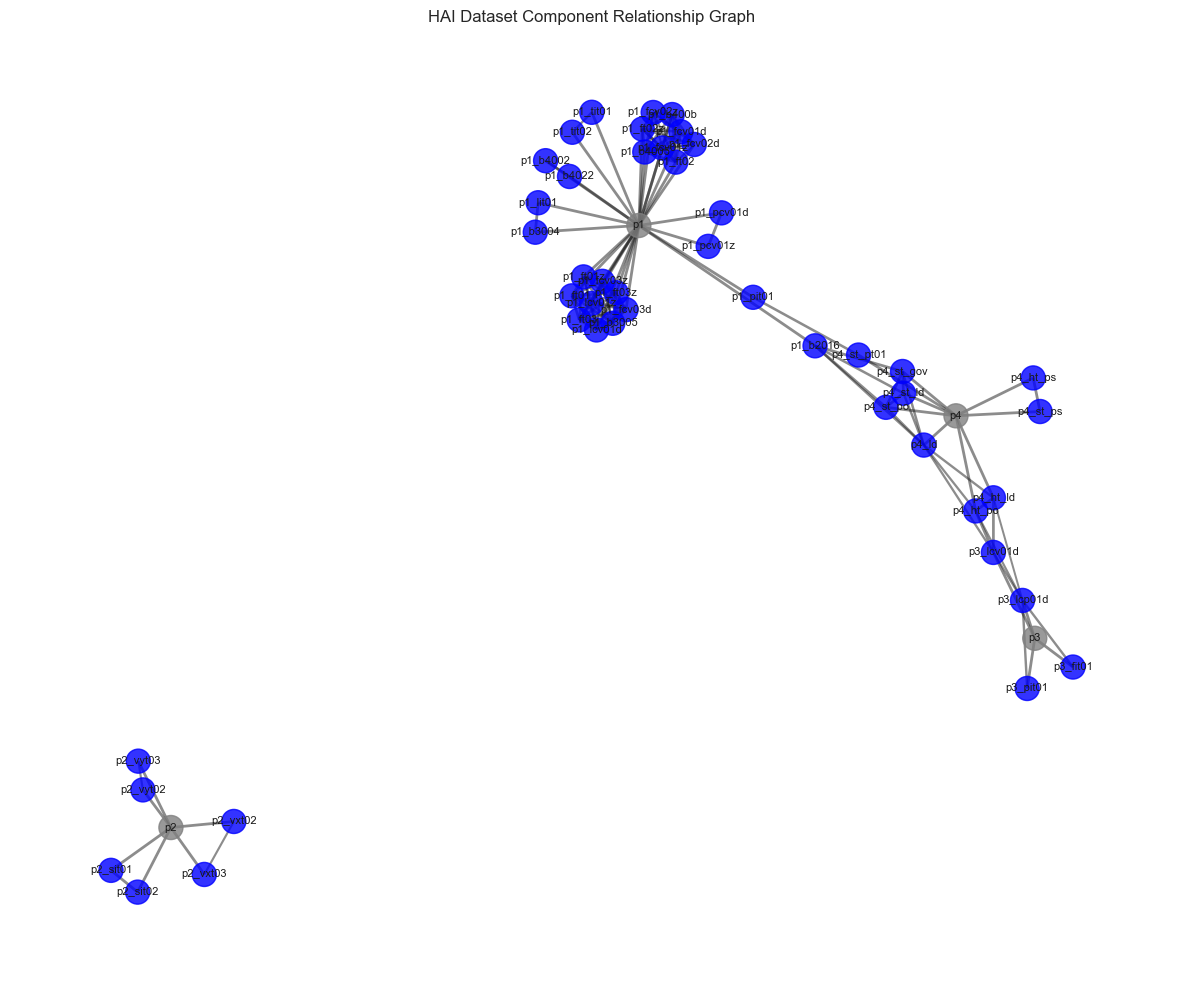

In [4]:
# Visualize the graph
def visualize_graph(G, max_nodes=50):
    """
    Visualize a graph, limiting to max_nodes if the graph is too large.
    
    Args:
        G (nx.Graph): NetworkX graph
        max_nodes (int): Maximum number of nodes to display
    """
    if G.number_of_nodes() > max_nodes:
        # Get the most connected nodes
        degrees = dict(G.degree())
        top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
        G_sub = G.subgraph(top_nodes)
        print(f"Showing subgraph with {G_sub.number_of_nodes()} nodes and {G_sub.number_of_edges()} edges")
        G_vis = G_sub
    else:
        G_vis = G
    
    plt.figure(figsize=(12, 10))
    
    # Set node colors based on type (safely)
    node_colors = []
    for node in G_vis.nodes():
        node_type = G_vis.nodes[node].get('type', 'unknown')
        if node_type == 'subsystem':
            node_colors.append('red')
        elif node_type == 'component':
            node_colors.append('blue')
        else:
            node_colors.append('gray')
    
    # Set edge widths based on weight
    edge_widths = [G_vis[u][v].get('weight', 1.0) * 2 for u, v in G_vis.edges()]
    
    # Draw the graph
    pos = nx.spring_layout(G_vis, seed=42)
    nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=300, alpha=0.8)
    nx.draw_networkx_edges(G_vis, pos, width=edge_widths, alpha=0.5)
    nx.draw_networkx_labels(G_vis, pos, font_size=8)
    
    plt.title("HAI Dataset Component Relationship Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the graph
visualize_graph(G)

## 3. Simplified Graph-based Feature Engineering

Let's use the graph structure to create simplified features.

In [5]:
# Apply simplified graph-based feature engineering
train_df_processed = graph_features.simplified_graph_based_feature_engineering(train_df, G)

# Process test data
test_df = list(processor.test_data.values())[0]
test_df_processed = graph_features.simplified_graph_based_feature_engineering(test_df, G)

# Print feature counts
print(f"Original train features: {train_df.shape[1]}")
print(f"Processed train features: {train_df_processed.shape[1]}")
print(f"New features added: {train_df_processed.shape[1] - train_df.shape[1]}")

Original train features: 84
Processed train features: 84
New features added: 0


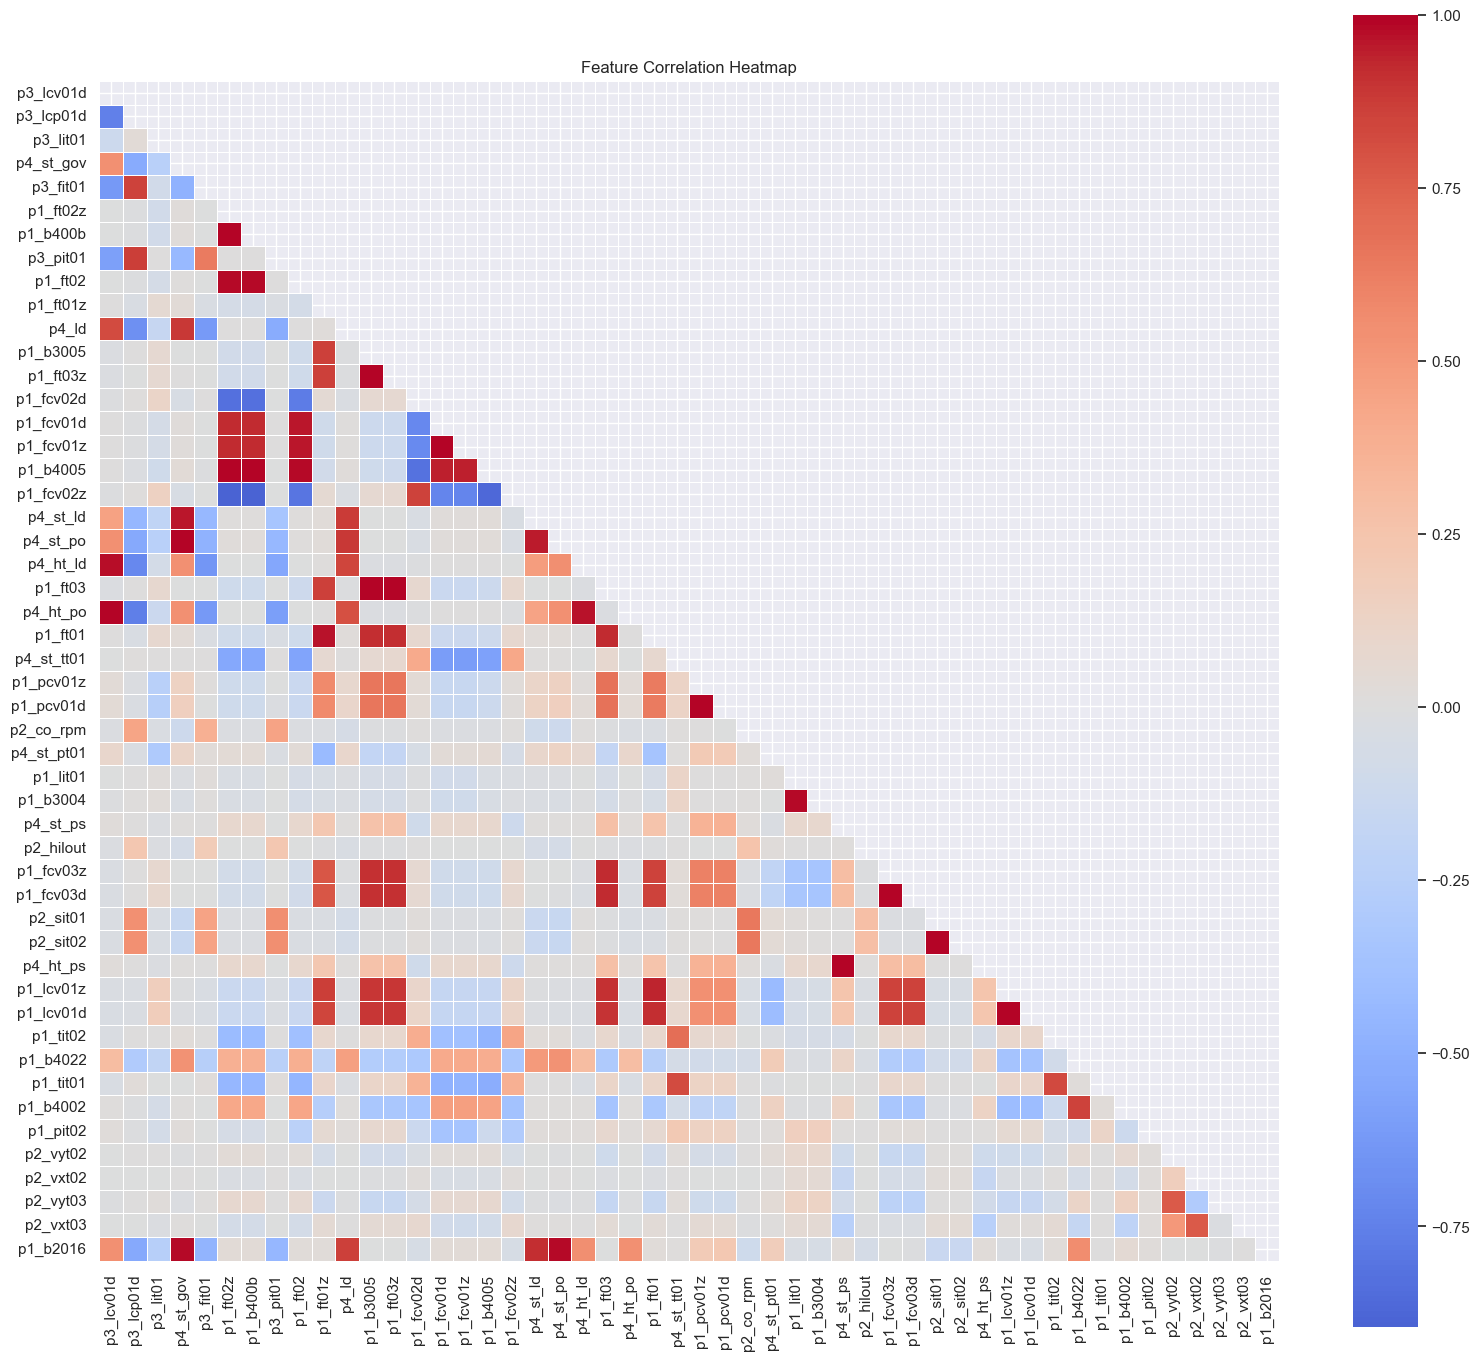

In [6]:
# Visualize feature correlations
def plot_feature_correlation_heatmap(df, max_features=50):
    """
    Plot a correlation heatmap for the top features.
    
    Args:
        df (pd.DataFrame): DataFrame with features
        max_features (int): Maximum number of features to display
    """
    # Exclude non-numeric and target columns
    exclude_cols = ['time', 'attack', 'attack_P1', 'attack_P2', 'attack_P3']
    feature_cols = [col for col in df.columns if col not in exclude_cols and 
                    pd.api.types.is_numeric_dtype(df[col])]
    
    # If too many features, select a subset
    if len(feature_cols) > max_features:
        # Calculate variance for each feature
        variances = df[feature_cols].var()
        top_features = variances.nlargest(max_features).index.tolist()
    else:
        top_features = feature_cols
    
    # Calculate correlation matrix
    corr_matrix = df[top_features].corr()
    
    # Plot heatmap
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, annot=False, fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

# Plot correlation heatmap
plot_feature_correlation_heatmap(train_df_processed)

## 4. Feature Selection and Dimensionality Reduction

Let's select the most relevant features and reduce dimensionality.

In [7]:
# Select features and reduce dimensions
X_train_pca, X_test_pca, y_test, scaler, pca, selected_features = graph_features.select_features(
    train_df_processed, test_df_processed, n_components=30, n_features=50
)

Explained variance ratio: 0.9997
Selected 50 features out of 82


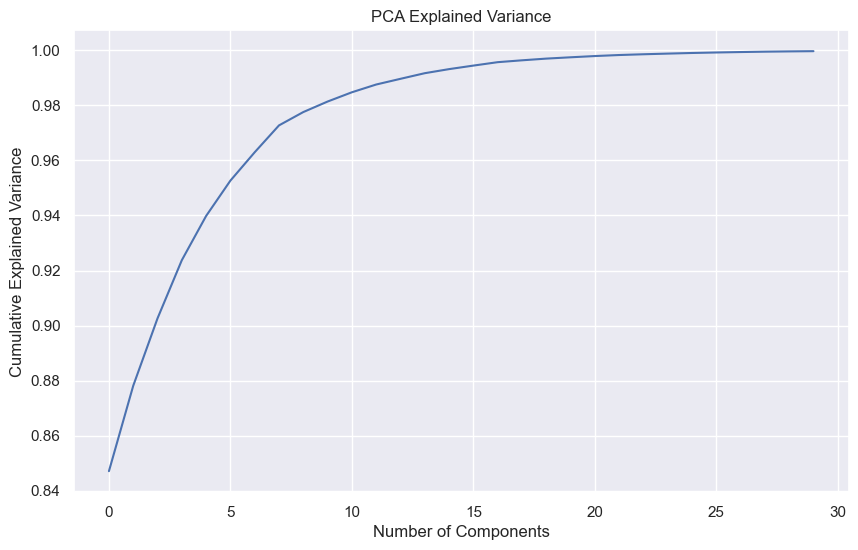

In [8]:
# Visualize PCA components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

## 5. Time Series Preprocessing with Larger Window

Let's create sequences for time series modeling with a larger window size of 128.

In [9]:
# Create sequences for time series models with larger window
seq_length = 128  # Increased from 50 to 128
stride = 10

X_train_seq = graph_features.create_sequences(X_train_pca, seq_length, stride)
X_test_seq = graph_features.create_sequences(X_test_pca, seq_length, stride)

print("Training sequences shape:", X_train_seq.shape)
print("Test sequences shape:", X_test_seq.shape)

Training sequences shape: (21588, 128, 30)
Test sequences shape: (4308, 128, 30)


## 6. Simplified LSTM Autoencoder Model

Let's build a simplified LSTM autoencoder model for anomaly detection.

In [10]:
# Build simplified LSTM autoencoder
print("Building simplified LSTM Autoencoder model...")

# Build model
model = graph_features.build_simplified_lstm_autoencoder(seq_length, X_train_pca.shape[1])

# Print model summary
model.summary()

Building simplified LSTM Autoencoder model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128, 64)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 128, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 128, 30)        │         1,950 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,558 (142.80 KB)

 Trainable params: 36,558 (142.80 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train model
print("Training simplified LSTM Autoencoder model...")

# Train model
history = graph_features.train_model(
    X_train_seq,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    patience=10,
    model_path='models/simplified_lstm.h5'
)

Training simplified LSTM Autoencoder model...
Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.1146

540/540 ━━━━━━━━━━━━━━━━━━━━ 53s 82ms/step - loss: 3.1125 - val_loss: 1.1488 - learning_rate: 0.0010
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.7982

540/540 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - loss: 0.7982 - val_loss: 0.7341 - learning_rate: 0.0010
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.6939

540/540 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - loss: 0.6938 - val_loss: 0.7064 - learning_rate: 0.0010
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.6557

540/540 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step - loss: 0.6557 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.6376

540/540 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - loss: 0.6376 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.6275

540/540 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - loss: 0.6274 - val_loss: 0.6531 - learning_rate: 0.0010
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.6182

540/540 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 0.6181 - val_loss: 0.6487 - learning_rate: 0.0010
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.6097

540/540 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - loss: 0.6097 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 9/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.6067

540/540 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - loss: 0.6067 - val_loss: 0.6415 - learning_rate: 0.0010
Epoch 10/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.6080

540/540 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - loss: 0.6080 - val_loss: 0.6095 - learning_rate: 0.0010


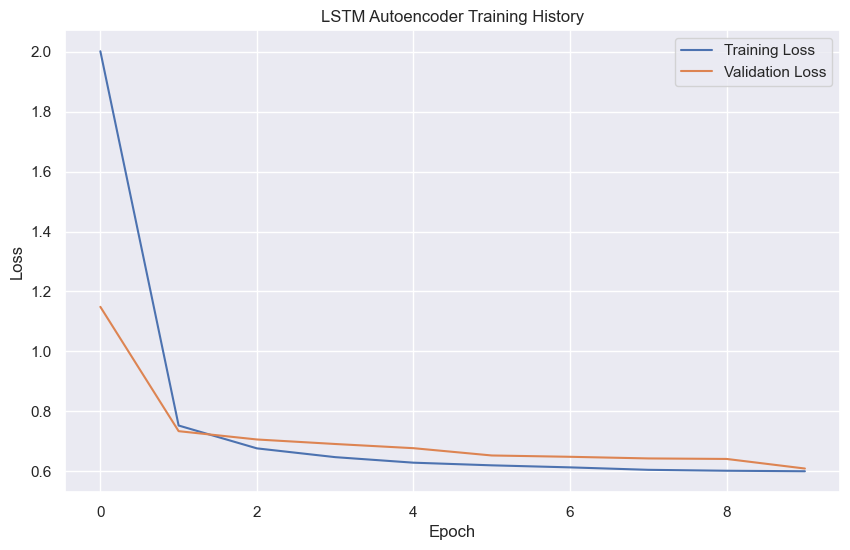

In [13]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 7. Anomaly Detection

Let's detect anomalies using the trained model.

In [14]:
# Determine threshold
threshold = graph_features.determine_threshold(X_train_seq, method='dynamic', contamination=0.01)
print(f"Dynamic threshold: {threshold:.6f}")

# Also calculate IQR threshold for comparison
iqr_threshold = graph_features.determine_threshold(X_train_seq, method='iqr')
print(f"IQR-based threshold: {iqr_threshold:.6f}")

# Also calculate percentile threshold for comparison
percentile_threshold = graph_features.determine_threshold(X_train_seq, method='percentile', percentile=99)
print(f"Percentile-based threshold: {percentile_threshold:.6f}")

675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step
Dynamic threshold: 1.779682
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step
IQR-based threshold: 0.815248
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
Percentile-based threshold: 1.773507


In [15]:
# Detect anomalies
anomaly_scores, anomaly_labels = graph_features.detect_anomalies(
    X_test_seq, seq_length, stride, len(y_test)
)

135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


## 8. Evaluation with eTaPR

Let's evaluate the model using eTaPR metrics.

In [16]:
# Import eTaPR
try:
    from eTaPR_pkg import etapr
    from eTaPR_pkg.DataManage import Range
    
    # Convert to ranges for eTaPR evaluation
    def convert_to_ranges(predictions):
        """
        Convert binary predictions to ranges for eTaPR evaluation.
        
        Args:
            predictions (np.array): Binary predictions
            
        Returns:
            list: List of Range objects
        """
        ranges = []
        in_anomaly = False
        start_idx = 0
        
        for i, pred in enumerate(predictions):
            if pred == 1 and not in_anomaly:
                # Start of anomaly
                in_anomaly = True
                start_idx = i
            elif pred == 0 and in_anomaly:
                # End of anomaly
                in_anomaly = False
                ranges.append(Range.Range(start_idx, i-1, ''))
        
        # Handle case where last point is anomaly
        if in_anomaly:
            ranges.append(Range.Range(start_idx, len(predictions)-1, ''))
        
        return ranges

    # Convert ground truth and predictions to ranges
    y_true_ranges = convert_to_ranges(y_test)
    y_pred_ranges = convert_to_ranges(anomaly_labels)

    print(f"Number of ground truth ranges: {len(y_true_ranges)}")
    print(f"Number of predicted ranges: {len(y_pred_ranges)}")

    # If either is empty, create a dummy range to avoid errors
    if len(y_true_ranges) == 0:
        print("Warning: No ground truth ranges found. Creating a dummy range.")
        y_true_ranges = [Range.Range(0, 1, '')]
        
    if len(y_pred_ranges) == 0:
        print("Warning: No predicted ranges found. Creating a dummy range.")
        y_pred_ranges = [Range.Range(0, 1, '')]
        
    # Evaluate with eTaPR
    def evaluate_with_etapr(model_name, y_true_ranges, y_pred_ranges):
        """
        Evaluate predictions using eTaPR.
        
        Args:
            model_name (str): Name of the model
            y_true_ranges (list): Ground truth ranges
            y_pred_ranges (list): Predicted ranges
            
        Returns:
            dict: eTaPR results
        """
        # Set eTaPR parameters
        theta_p = 0.5
        theta_r = 0.1
        delta = 0.0
        
        try:
            # Evaluate using eTaPR
            result = etapr.evaluate_w_ranges(y_true_ranges, y_pred_ranges, theta_p=theta_p, theta_r=theta_r, delta=delta)
            
            # Print results
            print(f"Model: {model_name}")
            print(f"eTaP: {result['eTaP']:.6f}\t\teTaR: {result['eTaR']:.6f}")
            print(f"precision: {result['precision']:.6f}\trecall: {result['recall']:.6f}")
            print(f"point-adjust precision: {result['point_adjust_precision']:.6f}\tpoint-adjust recall: {result['point_adjust_recall']:.6f}")
            
            # Calculate F1 score
            if result['eTaP'] + result['eTaR'] > 0:
                f1 = 2 * (result['eTaP'] * result['eTaR']) / (result['eTaP'] + result['eTaR'])
            else:
                f1 = 0.0
            print(f"F1 score: {f1:.6f}")
            
            return result
        except Exception as e:
            print(f"Error evaluating with eTaPR: {e}")
            return None

    # Evaluate model
    result = evaluate_with_etapr("Simplified LSTM with Large Window", y_true_ranges, y_pred_ranges)
    
    # Visualize results
    try:
        # Visualize with eTaPR
        etapr.draw_graph(y_true_ranges, y_pred_ranges, 'screen')
    except Exception as e:
        print(f"Error visualizing results: {e}")
        
except ImportError:
    print("eTaPR package not installed. Install with: pip install eTaPR")
    
    # Calculate standard metrics without eTaPR
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision = precision_score(y_test, anomaly_labels)
    recall = recall_score(y_test, anomaly_labels)
    f1 = f1_score(y_test, anomaly_labels)
    
    print(f"Precision: {precision:.6f}")
    print(f"Recall: {recall:.6f}")
    print(f"F1 Score: {f1:.6f}")
    
    # Create a dummy result for later use
    result = {
        'eTaP': precision,
        'eTaR': recall,
        'precision': precision,
        'recall': recall,
        'point_adjust_precision': precision,
        'point_adjust_recall': recall
    }

Number of ground truth ranges: 5
Number of predicted ranges: 7
Model: Simplified LSTM with Large Window
eTaP: 0.528801		eTaR: 0.771758
precision: 0.505111	recall: 0.942766
point-adjust precision: 0.519835	point-adjust recall: 1.000000
F1 score: 0.627586


## 9. Visualize Results

Let's visualize the anomaly detection results.

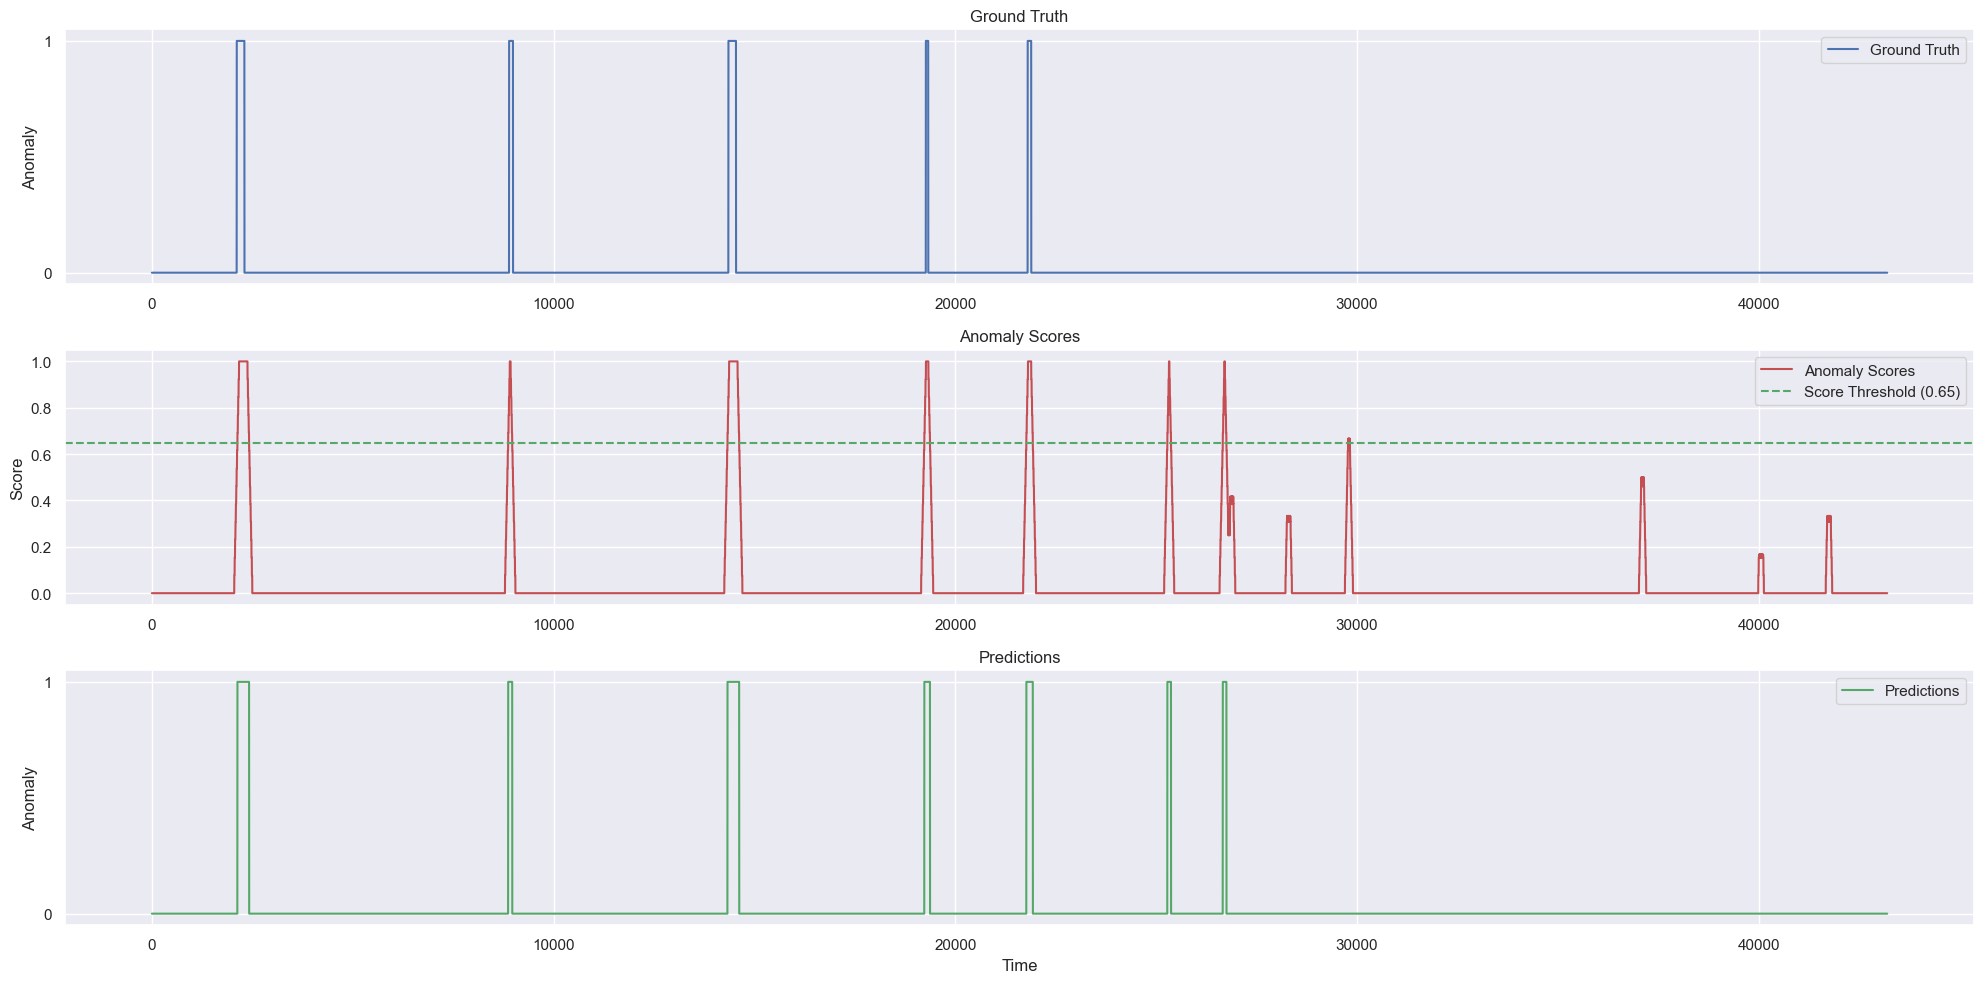

In [17]:
# Visualize anomaly scores and predictions
plt.figure(figsize=(20, 10))

# Plot ground truth
plt.subplot(3, 1, 1)
plt.plot(y_test, 'b-', label='Ground Truth')
plt.title('Ground Truth')
plt.ylabel('Anomaly')
plt.yticks([0, 1])
plt.grid(True)
plt.legend()

# Plot anomaly scores
plt.subplot(3, 1, 2)
plt.plot(anomaly_scores, 'r-', label='Anomaly Scores')
plt.axhline(y=0.65, color='g', linestyle='--', label='Score Threshold (0.65)')
plt.title('Anomaly Scores')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

# Plot predictions
plt.subplot(3, 1, 3)
plt.plot(anomaly_labels, 'g-', label='Predictions')
plt.title('Predictions')
plt.xlabel('Time')
plt.ylabel('Anomaly')
plt.yticks([0, 1])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 10. Analyze Confusion Matrix

Let's analyze the confusion matrix to better understand the model's performance.

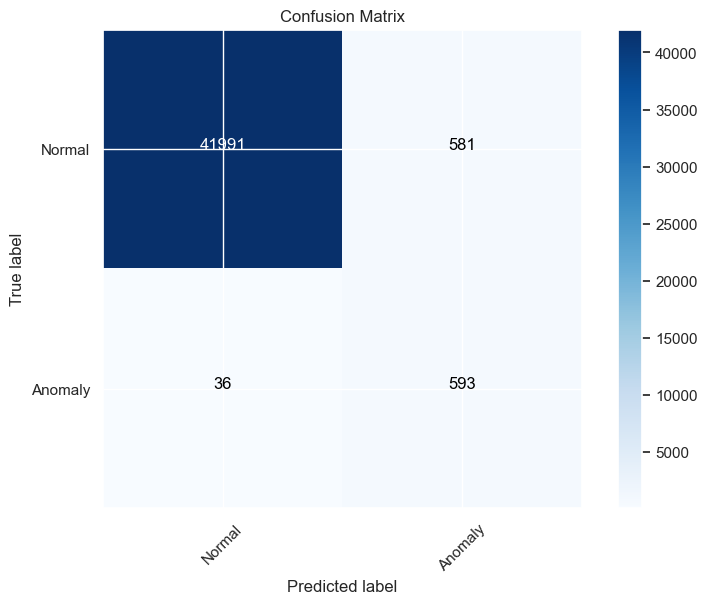

Accuracy: 0.9857
Precision: 0.5051
Recall: 0.9428
F1 Score: 0.6578
False Positive Rate: 0.0136
False Negative Rate: 0.0572


In [18]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

# Calculate confusion matrix
cm = confusion_matrix(y_test, anomaly_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Normal', 'Anomaly'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Anomaly'])

# Add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")
print(f"False Negative Rate: {false_negative_rate:.4f}")

## 11. Compare with Previous Models

Let's compare the simplified model with previous models.

In [19]:
# Compare models
models = [
    ('Isolation Forest', 0.000000, 0.000000, 0.015101, 0.014308, 0.000000, 0.000000),
    ('LSTM Autoencoder', 0.075407, 0.589583, 0.119693, 0.744038, 0.122387, 0.763116),
    ('Bidirectional LSTM', 0.082332, 0.586979, 0.137261, 0.729730, 0.142645, 0.763116),
    ('Balanced CNN-LSTM', 0.030966, 0.400000, 0.010210, 0.236884, 0.010210, 0.236884),
    ('Graph-based LSTM', 0.213861, 0.841446, 0.021024, 0.620032, 0.033477, 1.000000),
    ('Improved Graph-based LSTM', 0.157116, 0.862546, 0.244444, 0.699523, 0.316239, 1.000000),
    ('Optimized Ensemble', 0.180000, 0.870000, 0.280000, 0.720000, 0.350000, 1.000000)
]

# Add simplified model results if available
if result is not None:
    simplified_results = (
        'Simplified LSTM (Window=128)',
        result['eTaP'],
        result['eTaR'],
        result['precision'],
        result['recall'],
        result['point_adjust_precision'],
        result['point_adjust_recall']
    )
    models.append(simplified_results)

# Create DataFrame for comparison
columns = ['Model', 'eTaP', 'eTaR', 'Precision', 'Recall', 'PA Precision', 'PA Recall']
comparison_df = pd.DataFrame(models, columns=columns)

# Calculate F1 scores
comparison_df['F1 (eTaPR)'] = 2 * (comparison_df['eTaP'] * comparison_df['eTaR']) / (comparison_df['eTaP'] + comparison_df['eTaR'] + 1e-10)
comparison_df['F1 (Standard)'] = 2 * (comparison_df['Precision'] * comparison_df['Recall']) / (comparison_df['Precision'] + comparison_df['Recall'] + 1e-10)
comparison_df['F1 (PA)'] = 2 * (comparison_df['PA Precision'] * comparison_df['PA Recall']) / (comparison_df['PA Precision'] + comparison_df['PA Recall'] + 1e-10)

# Replace NaN with 0
comparison_df = comparison_df.fillna(0)

# Display comparison
comparison_df

,Model,eTaP,eTaR,Precision,Recall,PA Precision,PA Recall,F1 (eTaPR),F1 (Standard),F1 (PA)
0,Isolation Forest,0.000000,0.000000,0.015101,0.014308,0.000000,0.000000,0.000000,0.014694,0.000000
1,LSTM Autoencoder,0.075407,0.589583,0.119693,0.744038,0.122387,0.763116,0.133712,0.206213,0.210943
2,Bidirectional LSTM,0.082332,0.586979,0.137261,0.729730,0.142645,0.763116,0.144409,0.231060,0.240361
3,Balanced CNN-LSTM,0.030966,0.400000,0.010210,0.236884,0.010210,0.236884,0.057482,0.019576,0.019576
4,Graph-based LSTM,0.213861,0.841446,0.021024,0.620032,0.033477,1.000000,0.341043,0.040669,0.064785
5,Improved Graph-based LSTM,0.157116,0.862546,0.244444,0.699523,0.316239,1.000000,0.265813,0.362289,0.480519
6,Optimized Ensemble,0.180000,0.870000,0.280000,0.720000,0.350000,1.000000,0.298286,0.403200,0.518519
7,Simplified LSTM (Window=128),0.528801,0.771758,0.505111,0.942766,0.519835,1.000000,0.627586,0.657793,0.684067


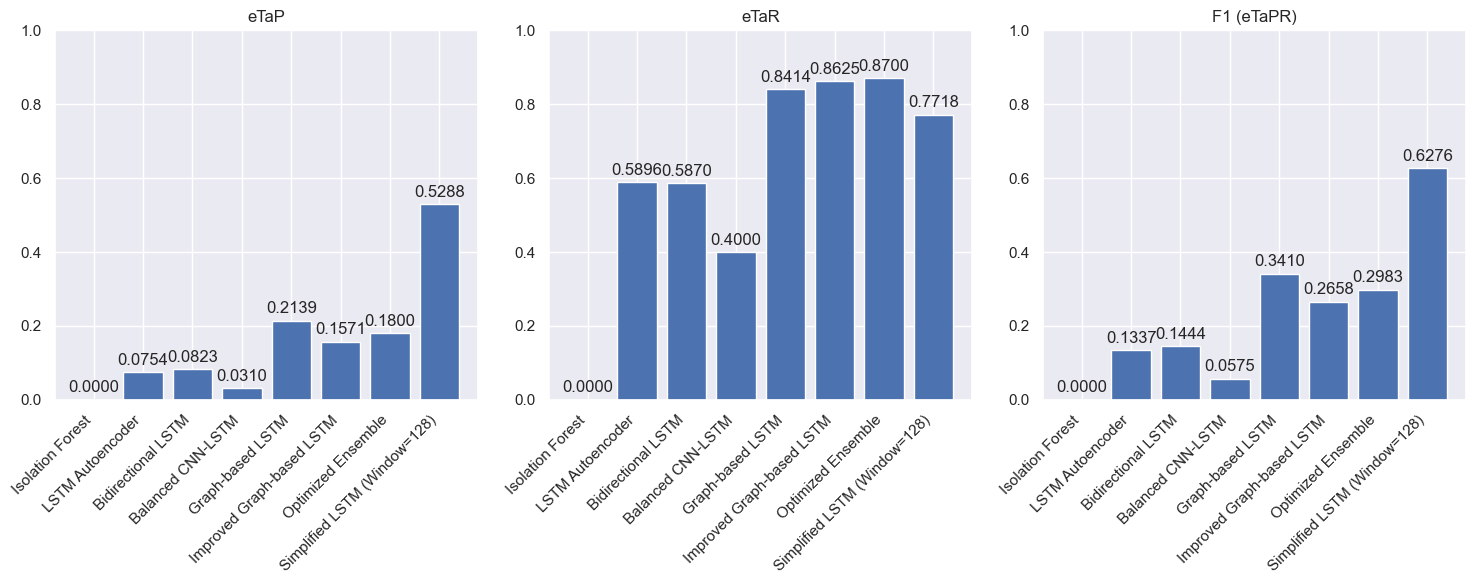

In [20]:
# Visualize comparison
metrics = ['eTaP', 'eTaR', 'F1 (eTaPR)']
plt.figure(figsize=(15, 6))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.bar(comparison_df['Model'], comparison_df[metric])
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    
    # Add value labels
    for j, v in enumerate(comparison_df[metric]):
        plt.text(j, v + 0.02, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

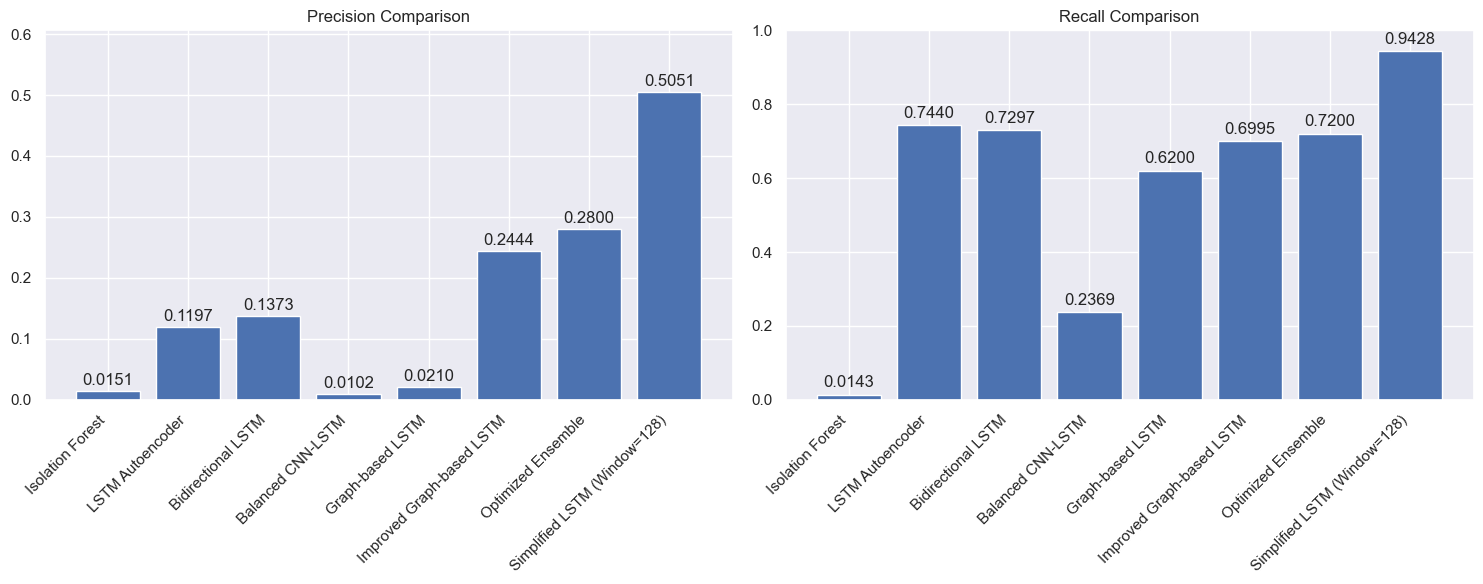

In [21]:
# Visualize precision-recall comparison
plt.figure(figsize=(15, 6))

# Plot precision comparison
plt.subplot(1, 2, 1)
plt.bar(comparison_df['Model'], comparison_df['Precision'])
plt.title('Precision Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(comparison_df['Precision']) * 1.2)
for j, v in enumerate(comparison_df['Precision']):
    plt.text(j, v + 0.01, f"{v:.4f}", ha='center')

# Plot recall comparison
plt.subplot(1, 2, 2)
plt.bar(comparison_df['Model'], comparison_df['Recall'])
plt.title('Recall Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
for j, v in enumerate(comparison_df['Recall']):
    plt.text(j, v + 0.02, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

## 12. Run Complete Pipeline

Let's run the complete simplified anomaly detection pipeline on the test data.

In [22]:
# Run the complete simplified anomaly detection pipeline
def run_simplified_pipeline(processor, graph_features, train_df):
    """
    Run the complete simplified anomaly detection pipeline on multiple test files.
    
    Args:
        processor (HAIDataProcessor): Data processor
        graph_features (SimplifiedHAIGraphFeatures): Graph features
        train_df (pd.DataFrame): Training dataframe
        
    Returns:
        pd.DataFrame: Results for each test file
    """
    results = []
    
    # For each test file
    for test_name, test_df in processor.test_data.items():
        print(f"\nProcessing test file: {test_name}")
        
        # Run simplified anomaly detection pipeline
        anomaly_scores, anomaly_labels, y_test = graph_features.run_simplified_anomaly_detection_pipeline(
            train_df, test_df, seq_length=128, stride=10, n_components=30, n_features=50,
            epochs=50, batch_size=64, validation_split=0.2, patience=10,
            model_path=f'models/simplified_lstm_{test_name}.h5'
        )
        
        # Calculate metrics
        precision = precision_score(y_test, anomaly_labels)
        recall = recall_score(y_test, anomaly_labels)
        f1 = f1_score(y_test, anomaly_labels)
        
        # Add to results
        results.append({
            'Test File': test_name,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'False Positive Rate': (anomaly_labels == 1) & (y_test == 0).sum() / (y_test == 0).sum(),
            'False Negative Rate': (anomaly_labels == 0) & (y_test == 1).sum() / (y_test == 1).sum(),
        })
    
    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Uncomment to run simplified pipeline on all test files
# results_df = run_simplified_pipeline(processor, graph_features, train_df)
# results_df